# Copy Shad's LVL1 WX Code to Python
### InterpandAverageLVL2

In [71]:
#import external libraries
import pandas as pd
import os
pd.options.mode.chained_assignment = None  # default='warn'; chained index warning
import numpy as np
import imp
from scipy import signal
import datetime
import pytz

#plotting
import seaborn as sns; sns.set(style='whitegrid')
import matplotlib.pyplot as plt
%matplotlib notebook

#import self-written libraries
import CleanWxData as wx
import LVL1

In [106]:
imp.reload(LVL1)

<module 'LVL1' from 'C:\\Users\\ehbaker\\Documents\\Python\\Modules\\LVL1.py'>

** Define Baseline Settings **

In [73]:
#path to level 0 data
Glacier="Wolverine" #or "Gulkana"
Station="990" #or other elevations
timezone='America/Anchorage' #choose from pytz.all_timezones
pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL0/" + Glacier.lower()+"_990_ALL_15minLVL0.csv"
UTC_time_column_name='UTC_time'
date_format='%Y/%m/%d %H:%M'

### Data import and clean

In [74]:
#read in level0 CSV
dat=pd.read_csv(pth)

#TIME SHOULD BE DEALT WITH IN LEVEL0 PROCESSING (aka before this); LEVEL 0 will have time in UTC.
#I'm doing it here because it is currently NOT; shift this block to level 0 processing when possible.
dat['time']=pd.to_datetime(dat[UTC_time_column_name], format= date_format) #this is not actually UTC time; it's UTC-8
#dat=dat.set_index("time") #Set this time object as the index (for ease of indexing in Pandas dataframe)
dat['UTC']=dat.time + datetime.timedelta(hours=8) #This is now UTC time #THIS NAME MUST BE USED!

#Convert date to date-time object, and index of dataframe
dat['UTC']=pd.to_datetime(dat.UTC, format=date_format)
dat=dat.set_index("UTC") #Set this UTC time object as the index of the dataframe

#Timezone
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)
dat['local_time'] = dat.index.tz_localize('UTC').tz_convert(local_timezone)
dat=dat.set_index('local_time')

#Create QC-Flag identical dataframe - will store QC status of each value
dat_qc_info = pd.DataFrame().reindex_like(dat)

Station-specific Data Adjustments

In [75]:
# Wolverine990: Prior to 2014.04.20, asp. temperature only aspirated on the hour; other msmts set to NAN
if Glacier+Station=="Wolverine990":
    dat.loc[dat.index.minute!=0, 'TAspirated1']=np.nan
    dat_qc_info.loc[dat.index.minute!=0, 'TAspirated1']=1 #seet QC flag to 1, indicating removed values
    dat.loc[dat.index.minute!=0, 'TAspirated2']=np.nan
    dat_qc_info.loc[dat.index.minute!=0, 'TAspirated2']=1

In [76]:
#SAVE FOR FUTURE USE - extract the date as text, in desired format
#dat.index.tz_localize('UTC').tz_convert(local_timezone).strftime(date_format)

** Remove malfunctioning sensors manually **
* done separately for each timestep entered on look-up table

In [77]:
#read in table listing sensors and timeperiods that need to be modified
pth_bad_sensor_dates=r"Q:\Project Data\GlacierData\Benchmark_Program\Metadata\weather"
bad_sensor_dates_dat=pd.read_csv(os.path.join(pth_bad_sensor_dates, Glacier+Station+"_SensorLog.csv"))

#Set bad data to NAN. Move sensor data to correct column, if neccessary.
dat=LVL1.remove_malfunctioning_sensor_data(dat, bad_sensor_dates_dat)

** Set hard-coded cutoff values** (station specific)

In [78]:
if Glacier+Station=="Wolverine990":
    low_temp_cutoff=-40.0 #deg. C
    high_temp_cutoff=30.0

    precip_high_cutoff=0.015 #meters
    precip_drain_cutoff=-0.15
    obvious_error_precip_cutoff=0.3 #if 30 cm in 15 minutes, obviously an error.

Set data outside hard-coded cutoffs to NAN

In [80]:
#Temperature
temp_columns=['Tpassive1', 'Tpassive2', 'TAspirated1', 'TAspirated2']
for temp_col in temp_columns:
    temps=dat.loc[:,temp_col]
    dat.loc[:,temp_col]=LVL1.remove_error_temperature_values(temps, low_temp_cutoff, high_temp_cutoff)

In [81]:
#Precip
precip_columns=['TPGCumulative', 'StageCumulative']
precip_col=precip_columns[0]

# for precip_col in precip_columns:
#     precip=dat.loc[:,precip_col]
    

In [82]:
#Multiple precip columns
precip_columns=['TPGCumulative', 'StageCumulative']

precip_col=precip_columns[0] #create loop from here, going forwward (once finish the process)

#Precip
if Glacier + Station=="Wolverine990":
    Stage_dies='2015/09/01 06:30:00'
    TPG_born='2012/10/02 00:00:00'

#Set gages to NAN, when not installed (single gage style does not cover period of record)
dat.loc[:TPG_born, precip_col]=np.nan

In [83]:
#strip outlier values using a 6-sample Hampel filter
dat[precip_col]=LVL1.hampel(dat.TPGCumulative.values, k=3)

In [84]:
#Create an incremental timeseries for precip
dPrecip=precip_col.split("Cumulative")[0]+ "Incremental" #create name for new incremental column
dat[dPrecip]=dat[precip_col] - dat[precip_col].shift(1)
dat.ix[0,dPrecip]=0

In [88]:
#Remove issues associated with station maintenance

#Precip drain and fill
dat.loc[(dat[dPrecip]>precip_high_cutoff) & (dat.index.month>=8) & (dat.index.month<12), dPrecip]=0 #remove antifreeze fill
dat.loc[(dat[dPrecip]<precip_drain_cutoff), dPrecip]=0 #remove negative values associated with drain events

#Sensor malfunction, giving physically impossible high readings
dat.loc[dat[dPrecip]>0.3, dPrecip]=0 #cutoff: 30cm in 15 min


In [89]:
#re-create cumulative timeseries (delte - do we need this for any reason here?)
#dat['Stage2']=dat.StageIncremental.cumsum()
#dat['TPG2']=dat.TPGIncremental.cumsum()

dat_original_saveToCompare=dat.copy()

In [91]:
dat=dat['2013-02'].copy()

** Smooth timeseries **

In [107]:
dat_NEWWWW=LVL1.smooth_precip_Nayak2010(dat, dPrecip)

smoothing data in forward direction; may take a minute
done with forward smoothing
smoothing data in reverse direction; may take a minute
done with backwards


### Make some Plots now to show what we did

<IPython.core.display.Javascript object>


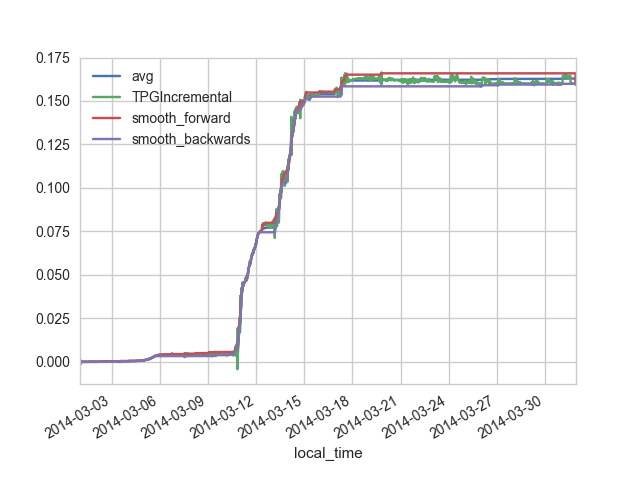

In [69]:
dat3[['avg', 'TPGIncremental', 'smooth_forward', 'smooth_backwards']].cumsum().plot()